
发现有效路径数量: 8

路径1结构: 爱因斯坦-导师->闵可夫斯基 → 闵可夫斯基-同事->希尔伯特 → 希尔伯特-任教->哥廷根大学
自然描述: None

路径2结构: 闵可夫斯基-同事->希尔伯特 → 爱因斯坦-导师->闵可夫斯基 → 爱因斯坦-出生地->乌尔姆
自然描述: None

路径3结构: 闵可夫斯基-同事->希尔伯特 → 爱因斯坦-导师->闵可夫斯基 → 爱因斯坦-提出->相对论
自然描述: None


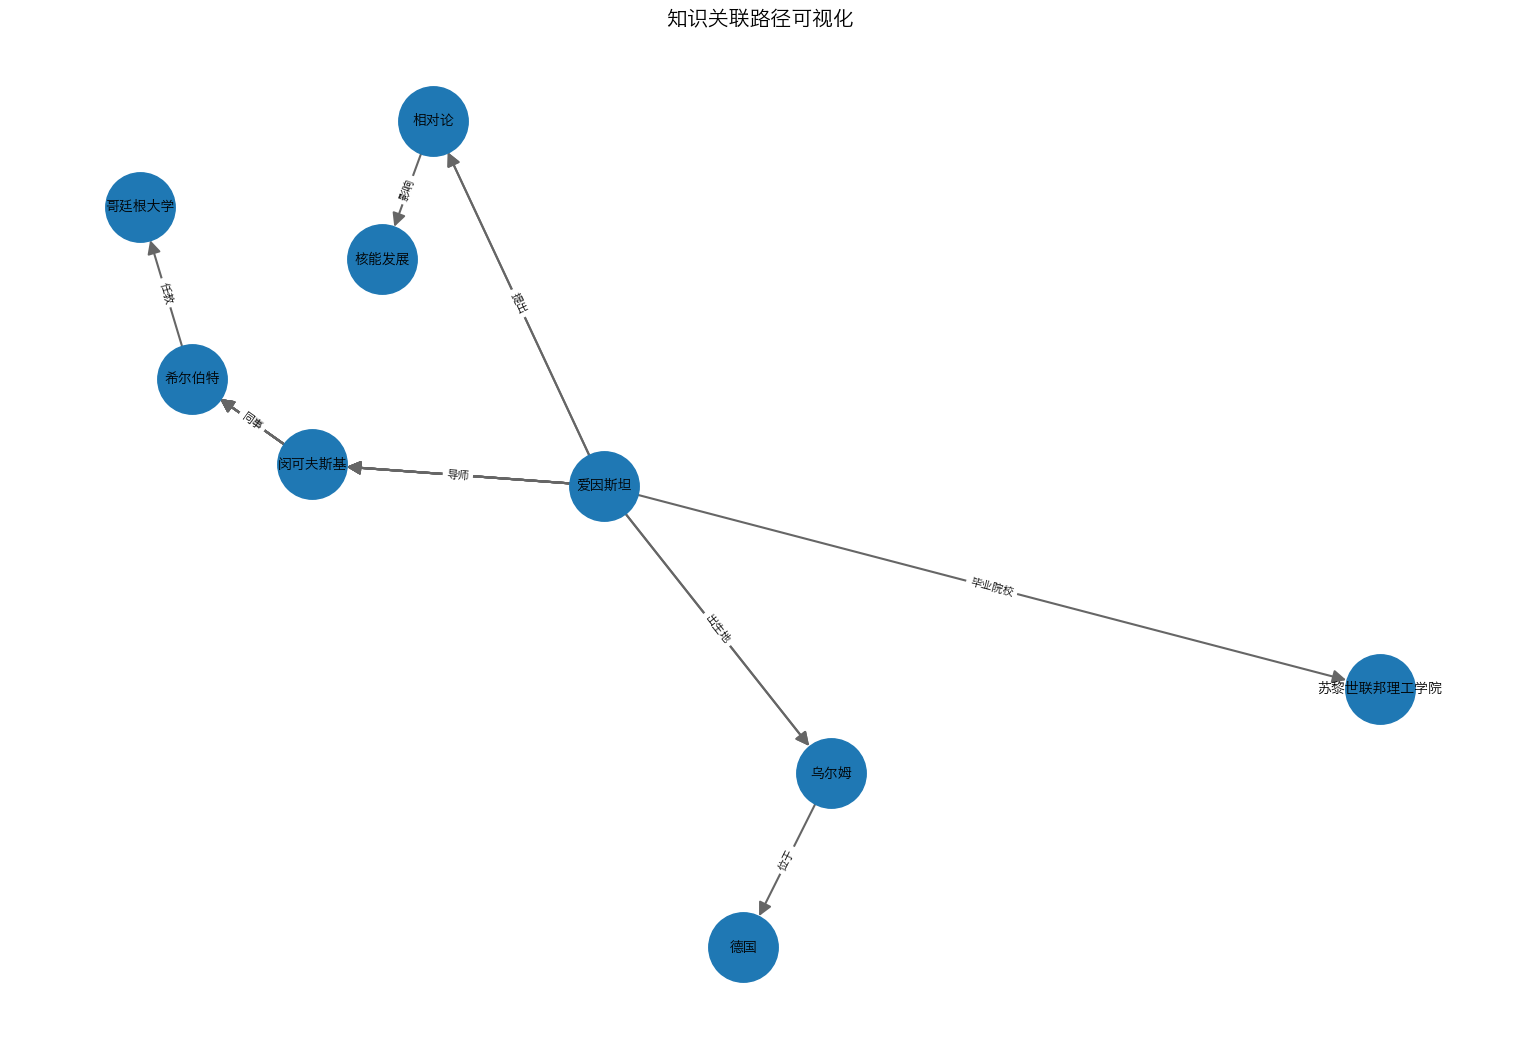

In [41]:
from rdflib import Graph, URIRef, Namespace
from itertools import islice
from typing import List, Tuple, Generator
from collections import deque

import networkx as nx
import matplotlib.pyplot as plt
import re

# --------------------- 配置参数 ---------------------
MAX_DEPTH = 4                # 最大路径深度
BATCH_SIZE = 1000            # 分批处理量
VISUALIZE_PATHS = 50         # 可视化路径数量

# --------------------- 核心类型定义 ---------------------
Node = URIRef
Path = List[Tuple[Node, URIRef, Node]]

# --------------------- 主要功能函数 ---------------------
def visualize_paths(paths: List[Path]) -> None:
    """兼容多平台的路径可视化"""
    # 字体配置
    try:
        plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Hiragino Sans GB']
    except:
        plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 构建可视化子图
    G = nx.MultiDiGraph()
    label_mapping = {}
    
    for path in paths[:VISUALIZE_PATHS]:
        for s, p, o in path:
            # 生成可读标签
            s_label = safe_label(s)
            o_label = safe_label(o)
            p_label = safe_label(p)
            
            G.add_edge(s_label, o_label, predicate=p_label)
            label_mapping[s] = s_label
            label_mapping[o] = o_label
    
    # 布局与绘制
    pos = nx.spring_layout(G, k=0.5, seed=42)
    plt.figure(figsize=(15, 10))
    
    # 绘制主图
    nx.draw(G, pos, with_labels=True,
           node_size=2500, font_size=10, 
           edge_color='#666', width=1.5, arrowsize=20)
    
    # 添加边标签
    edge_labels = {(u, v): data['predicate'] 
                  for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=8)
    
    plt.title("知识关联路径可视化", fontsize=15)
    plt.show()

# --------------------- 辅助函数 ---------------------
def load_knowledge_graph() -> Graph:
    """加载示例知识图谱"""
    g = Graph()
    data = """
        @prefix ex: <http://example.org/> .
        ex:爱因斯坦 ex:出生地 ex:乌尔姆 ;
                  ex:导师 ex:闵可夫斯基 ;
                  ex:提出 ex:相对论 ;
                  ex:毕业院校 ex:苏黎世联邦理工学院 .
        ex:乌尔姆 ex:位于 ex:德国 .
        ex:德国 ex:首都 ex:柏林 .
        ex:柏林 ex:拥有 ex:柏林大学 .
        ex:闵可夫斯基 ex:同事 ex:希尔伯特 .
        ex:希尔伯特 ex:任教 ex:哥廷根大学 .
        ex:相对论 ex:影响 ex:核能发展 .
    """
    g.parse(data=data, format="turtle")
    return g

def multi_source_bfs(g: Graph, sources: List[Node], max_depth: int) -> Generator[Path, None, None]:
    """改进的多源BFS，允许不同起点之间连接"""
    for source in sources:
        visited = {source}  # 只将当前起点标记为已访问
        queue = deque([(source, [], visited)])
        
        while queue:
            current, path, visited = queue.popleft()
            
            # 前向扩展
            for p, o in g.predicate_objects(current):
                if o not in visited:
                    new_visited = visited.copy()
                    new_visited.add(o)
                    new_path = path + [(current, p, o)]
                    yield new_path
                    if len(new_path) < max_depth:
                        queue.append((o, new_path, new_visited))
            
            # 反向扩展        
            for s, p in g.subject_predicates(current):
                if s not in visited:
                    new_visited = visited.copy()
                    new_visited.add(s)
                    new_path = path + [(s, p, current)]
                    yield new_path
                    if len(new_path) < max_depth:
                        queue.append((s, new_path, new_visited))

# --------------------- 修改后的主要功能函数 ---------------------
def find_related_paths(target_nodes: List[Node], 
                      min_targets: int = None) -> List[Path]:
    """
    动态查找包含目标节点的所有关联路径
    
    参数:
        target_nodes: 1-5个目标节点列表 
        min_targets: 最少需要包含的目标节点数（默认自动计算）
    
    返回:
        包含指定数量目标节点的路径列表
    """
    # 参数校验与默认值调整
    if not 1 <= len(target_nodes) <= 5:
        raise ValueError("目标节点数量需在1-5个之间")
    
    # 自动设置最小目标数逻辑优化
    min_targets = min_targets or max(1, len(target_nodes)-1)  # 至少需要1个目标
    
    # 初始化知识图谱（示例数据）
    g = load_knowledge_graph()
    
    # 多起点路径发现
    discovered_paths = multi_source_bfs(g, target_nodes, MAX_DEPTH)
    
    # 过滤有效路径（放宽过滤条件）
    valid_paths = [
        path for path in discovered_paths
        if contains_targets(path, target_nodes, min_targets)
    ]
    
    # 添加后处理流程
    return post_process(valid_paths, target_nodes)  # 传递targets参数

# --------------------- 修改后的过滤函数 ---------------------
def contains_targets(path: Path, 
                    targets: List[Node], 
                    min_count: int) -> bool:
    """检查路径中包含的不同目标节点数量"""
    target_uris = set(targets)  # 保持URIRef类型
    found_targets = set()
    
    for s, p, o in path:
        if s in target_uris:
            found_targets.add(s)
        if o in target_uris:
            found_targets.add(o)
    
    return len(found_targets) >= min_count  # 计算不同目标节点数

# --------------------- 修改后的后处理函数 ---------------------
def post_process(paths: List[Path], targets: List[Node]) -> List[Path]:  # 添加targets参数
    """修复作用域问题"""
    if not paths:
        return []
    
    # 去重时保留顺序
    seen = set()
    unique_paths = []
    for p in paths:
        t = tuple(p)
        if t not in seen:
            seen.add(t)
            unique_paths.append(p)
    
    # 按命中数排序
    return sorted(unique_paths, 
                key=lambda x: count_targets(x, targets), 
                reverse=True)

def count_targets(path: Path, targets: List[Node]) -> int:  # 添加参数
    """精确计数函数"""
    return sum(1 for s, p, o in path 
              if s in targets or p in targets or o in targets)



def safe_label(uri: Node) -> str:
    """生成安全的显示标签"""
    return str(uri).split('/')[-1]

# --------------------- 新增自然语言生成模块 ---------------------
from typing import List, Tuple, Dict
import random
from collections import defaultdict

# 自然语言模板配置
RELATION_TEMPLATES = {
    "导师": {
        "default": lambda s, o: f"{s}师从{o}",
        "reverse": lambda s, o: f"{o}指导{s}进行研究工作"
    },
    "同事": {
        "default": lambda s, o: f"{s}与{o}保持长期合作",
        "academic": lambda s, o: f"{s}和{o}在学术领域密切合作"
    },
    "出生地": lambda s, o: f"{s}出生于{o}",
    "位于": lambda s, o: f"{s}位于{o}境内",
    "default": lambda s, r, o: f"{s}与{o}存在{r}关系"
}

CONNECTORS = [
    "值得关注的是，", "在此期间，", "历史资料显示，", 
    "相关记录表明，", "需要特别指出的是，"
]

def encode_path(path: List[Tuple[Node, URIRef, Node]], 
               mode: str = "hybrid") -> str:
    """
    将路径编码为指定格式
    mode: compressed|verbose|hybrid
    """
    str_path = []
    for s, p, o in path:
        s_name = safe_label(s)
        p_name = safe_label(p)
        o_name = safe_label(o)
        str_path.append((s_name, p_name, o_name))
    
    if mode == "compressed":
        return " → ".join([f"{s}-{p}->{o}" for s,p,o in str_path])
    elif mode == "verbose":
        return generate_narrative(str_path)
    elif mode == "hybrid":
        return f"""
        【结构化路径】{encode_path(path, "compressed")}
        【自然描述】{generate_narrative(str_path)}
        """

def generate_narrative(path: List[Tuple[str, str, str]]) -> str:
    """生成连贯的自然语言描述"""
    sentences = []
    context = defaultdict(str)
    
    for i, (s, p, o) in enumerate(path):
        # 选择模板
        template = RELATION_TEMPLATES.get(p, RELATION_TEMPLATES["default"])
        
        # 处理不同类型的模板
        if isinstance(template, dict):
            # 字典中的模板函数
            template_func = template["academic" if "大学" in o else "default"]
            sentence = template_func(s, o)
        elif template == RELATION_TEMPLATES["default"]:
            # 默认模板需要三个参数
            sentence = template(s, p, o)
        else:
            # 其他直接模板函数
            sentence = template(s, o)
        
        # 添加连接词
        if i > 0:
            prev_o = path[i-1][2]
            connector = select_connector(prev_o, s, context)
            sentence = connector + sentence
        
        sentences.append(sentence)
        update_context(context, s, p, o)
    
    # 后处理优化
    return postprocess_narrative(". ".join(sentences))

def select_connector(prev_entity: str, curr_entity: str, context: dict) -> str:
    """智能选择连接词"""
    if context.get('last_subject') == curr_entity:
        return "其中，"
    return random.choice(CONNECTORS)

def update_context(context: dict, s: str, p: str, o: str):
    """更新上下文状态"""
    context.update({
        'last_subject': s,
        'last_relation': p,
        'entities': context.get('entities', set()) | {s, o}
    })

def postprocess_narrative(text: str) -> str:
    """润色生成的文本"""
    # 指代消解
    entities = sorted(
        list(set(re.findall(r'[\u4e00-\u9fa5]+', text))), 
        key=len, 
        reverse=True
    )
    for ent in entities[1:]:
        if text.count(ent) > 1:
            text = text.replace(ent, "其", 1)
    
    # 标点优化
    return re.sub(r'。+', '。', text).replace('..', '.')

# --------------------- 修改后的主程序 ---------------------
if __name__ == "__main__":
    # 定义目标节点
    EX = Namespace("http://example.org/")
    targets = [
        EX.爱因斯坦,
        EX.希尔伯特
    ]
    
    # 执行查询
    results = find_related_paths(targets, min_targets=2)
    
    # 输出增强结果
    print(f"\n发现有效路径数量: {len(results)}")
    for i, path in enumerate(results[:3]):
        # 结构化路径输出
        path_str = " → ".join(
            f"{safe_label(s)}-{safe_label(p)}->{safe_label(o)}"
            for s, p, o in path
        )
        print(f"\n路径{i+1}结构: {path_str}")
        
        # 自然语言描述输出
        narrative = encode_path(path, "compass")
        print(f"自然描述: {narrative}")
    
    # 可视化
    visualize_paths(results)